# Self-Driving Car Engineer Nanodegree
## Project: Advanced Lane Finding


In the following code camera calibration is performed. The code is based on [Udacity's](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb) example.

## Camera calibration

In [1]:
#Load nessesery modules and set up
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

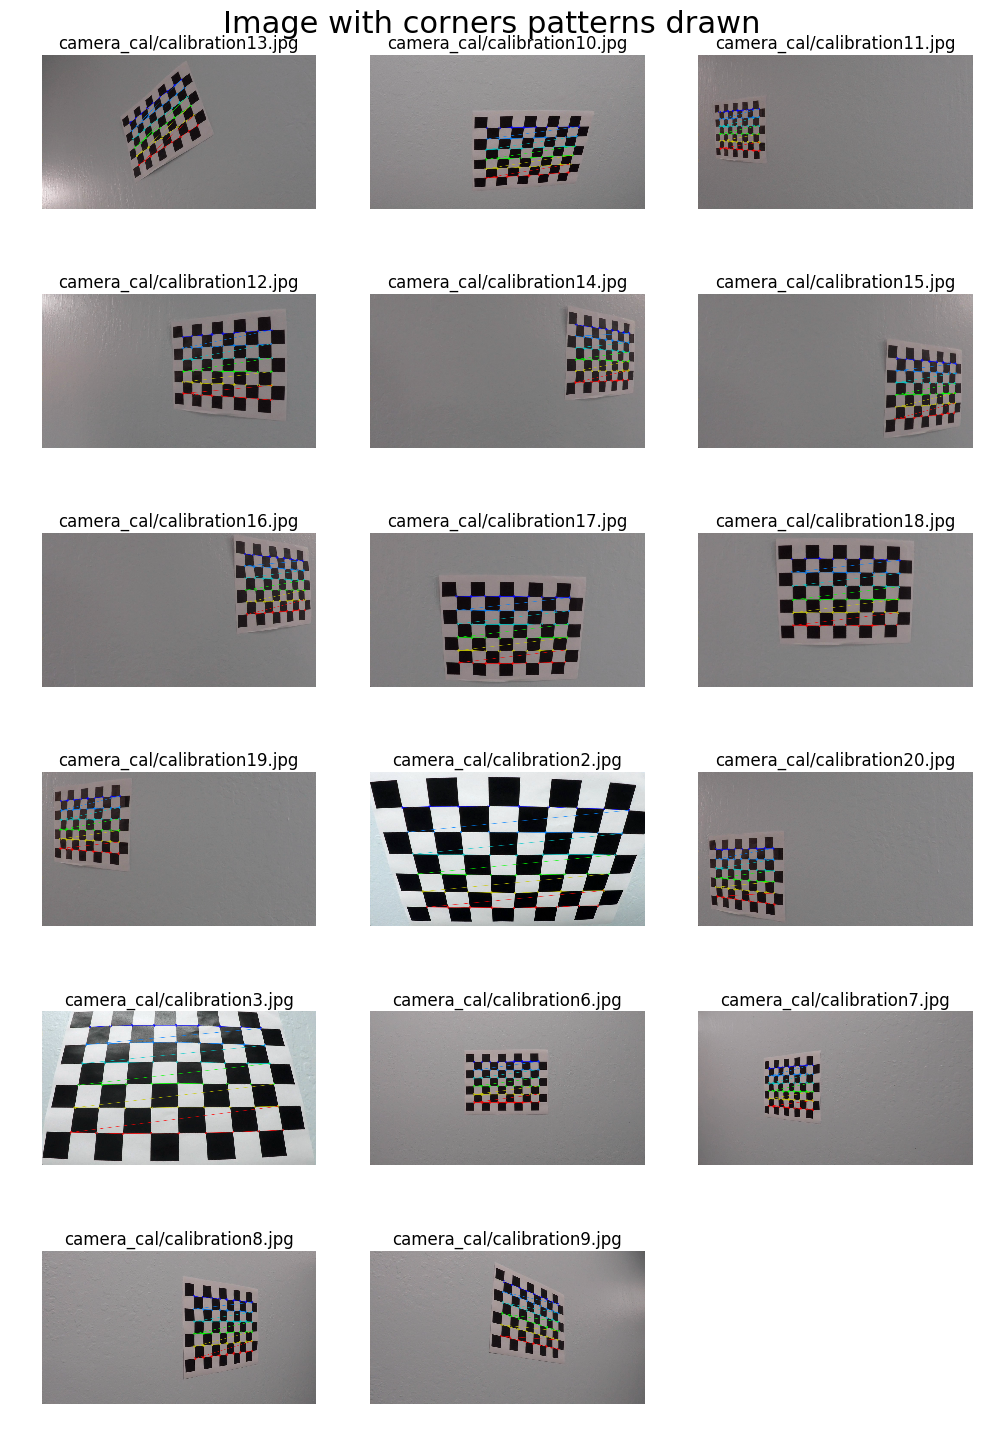

Corners were found on 17 out of 20 it is 85.0 % of calibration images


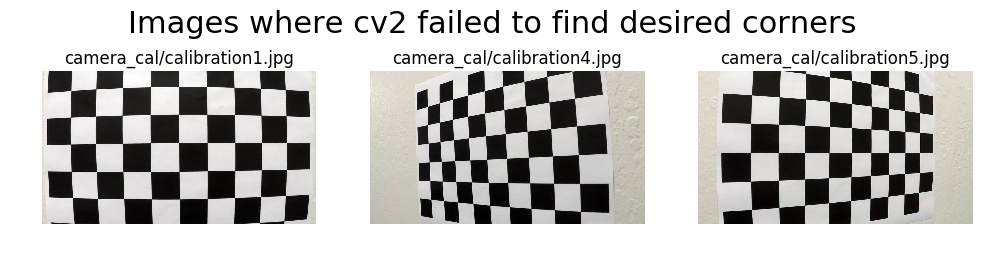

In [2]:
x_cor = 9 #Number of corners to find
y_cor = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((y_cor*x_cor,3), np.float32)
objp[:,:2] = np.mgrid[0:x_cor, 0:y_cor].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg') # Make a list of paths to calibration images
# Step through the list and search for chessboard corners
corners_not_found = [] #Calibration images in which opencv failed to find corners
plt.figure(figsize=(12, 18)) #Figure for calibration images
plt.figtext(0.5,0.9,'Image with corners patterns drawn', fontsize=22, ha='center')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (x_cor,y_cor), None) #Find the chessboard corners
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_cor,y_cor), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
        #write_name = 'readme_img/corners_found_'+str(len(imgpoints))+'.jpg'
        #cv2.imwrite(write_name, img)
    else:
        corners_not_found.append(fname)
plt.show()

#I use python 2.7
print 'Corners were found on', str(len(imgpoints)), 'out of', str(len(images)), 'it is',    str(len(imgpoints)*100.0/len(images)),'% of calibration images'

plt.figure(figsize=(12, 4))
plt.figtext(.5,.8,'Images where cv2 failed to find desired corners', fontsize=22, ha='center')
for i, p in enumerate(corners_not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) #draw the first image of each class
    plt.title(p)
    plt.axis('off')
plt.show()
#plt.savefig("readme_img/no_corners.jpg")

As we can see, 85% (17 out of 20) of calibration images were succesfully recognized by `cv2.findChessboardCorners`. The rest 3 images were not processed as the algorithm failed to find required number of corners. 

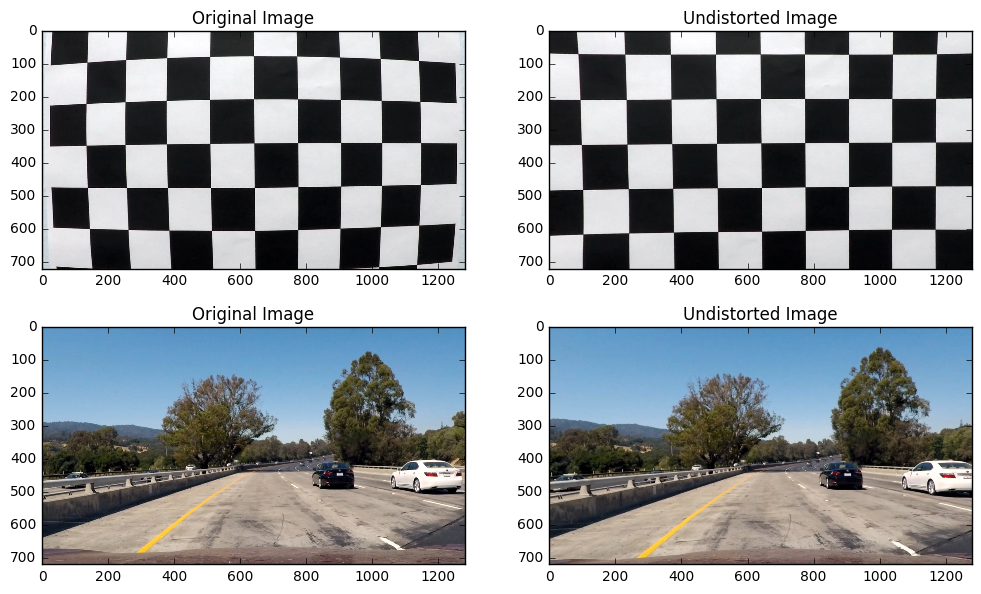

In [3]:
# Undistortion process
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")
img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")
plt.savefig("readme_img/undist_img.jpg")


## Create of thresholded binary image

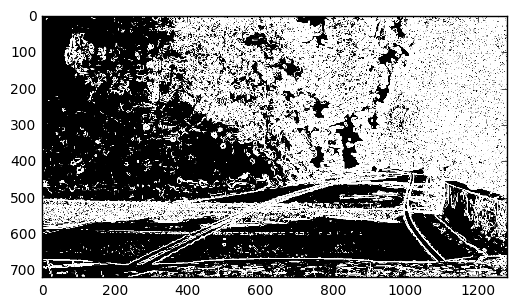

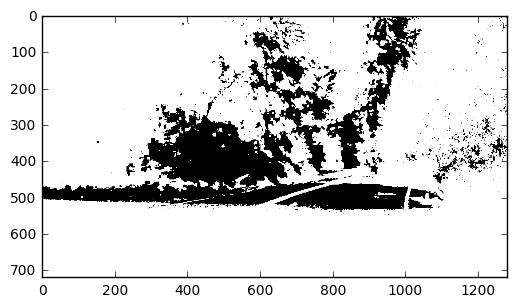

In [4]:
def eq_Hist(img):
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img

def sobel_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobelx = np.uint16(255*sobelx/np.max(sobelx))
    scaled_sobely = np.uint16(255*sobely/np.max(sobely))
    sobel_sum = scaled_sobelx+0.2*scaled_sobely
    scaled_sobel_sum = np.uint8(255*sobel_sum/np.max(sobel_sum))
    sum_binary = np.zeros_like(scaled_sobel_sum)
    sum_binary[(scaled_sobel_sum >= thresh_min) & (scaled_sobel_sum <= thresh_max)] = 1
    return sum_binary
    
def sobel_mag_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    gradmag_binary = np.zeros_like(scaled_gradmag)
    gradmag_binary[(scaled_gradmag >= thresh_min) & (scaled_gradmag <= thresh_max)] = 1
    return gradmag_binary

def sobel_dir_img(img, thresh_min = 0.0, thresh_max = 1.5, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    graddir = np.arctan2(sobely, sobelx)
    graddir_binary =  np.zeros_like(graddir)
    graddir_binary[(graddir >= thresh_min) & (graddir <= thresh_max)] = 1
    return  graddir_binary

def red_thres(img, thresh_min = 25, thresh_max = 255):
    red = img[:,:,2]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh_min) & (red <= thresh_max)]  = 1
    return red_binary
    
def s_thres(img, thresh_min = 25, thresh_max = 255):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary

def s_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]
    
def thres_img(img):
    img = eq_Hist(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #We use cv2.imread
    red = red_thres(img, 50, 255)
    res = sobel_mag_img(gray, 25, 255, 5)
    res1 = sobel_dir_img(gray, 0.6, 1.3, 5)
    combined = np.zeros_like(res)
    combined[((res == 1) & (res1 == 1))] = 1
    
    res = s_thres(img, 50, 255)
    return red
    

img = cv2.imread('test_images/test_ch.jpg')
img = eq_Hist(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(sobel_mag_img(gray, 10, 255,5), cmap='gray')
plt.figure()
plt.imshow(red_thres(img, 50, 255), cmap='gray')


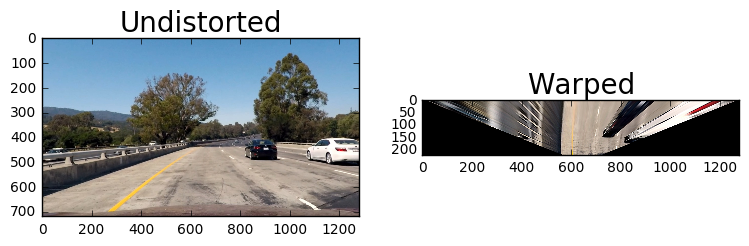

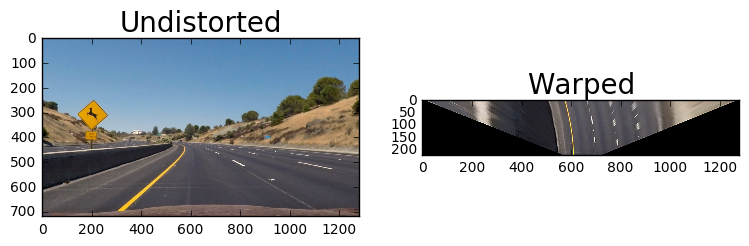

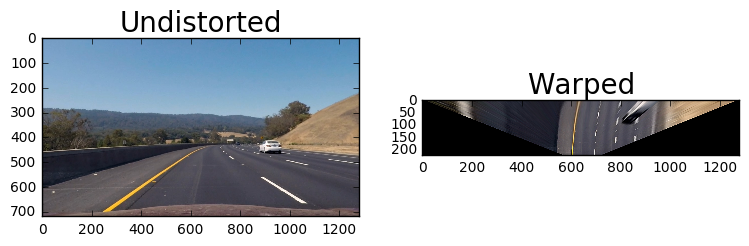

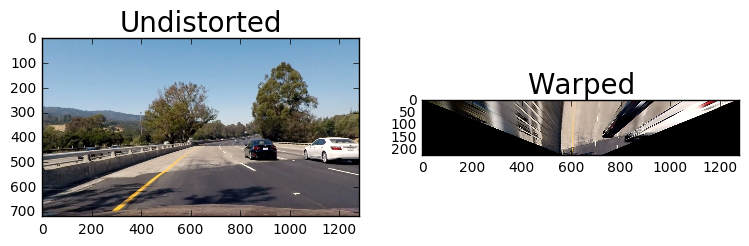

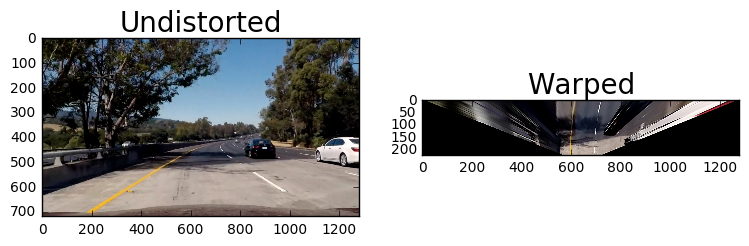

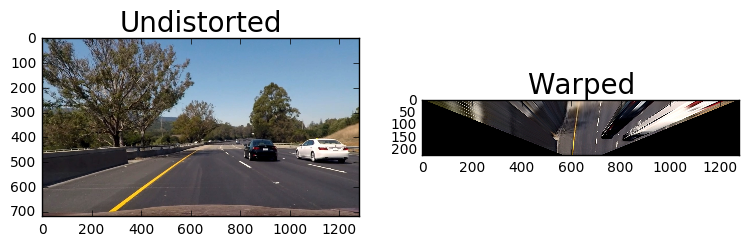

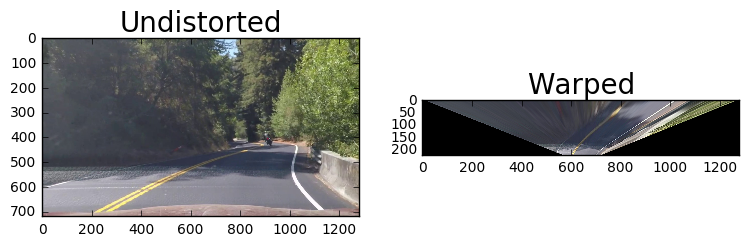

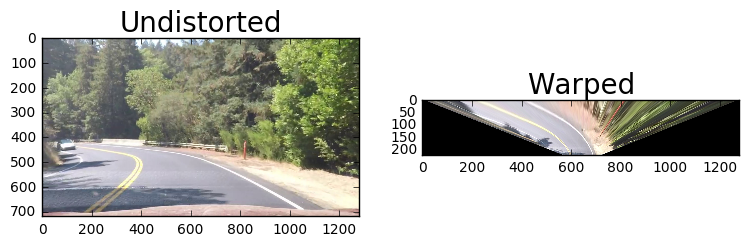

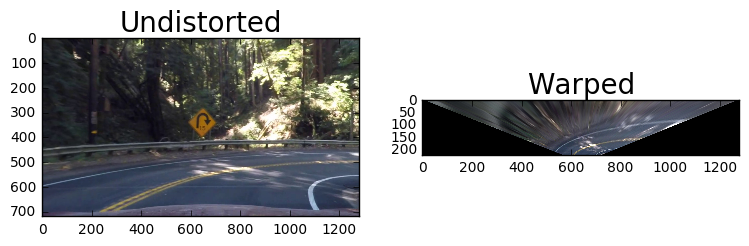

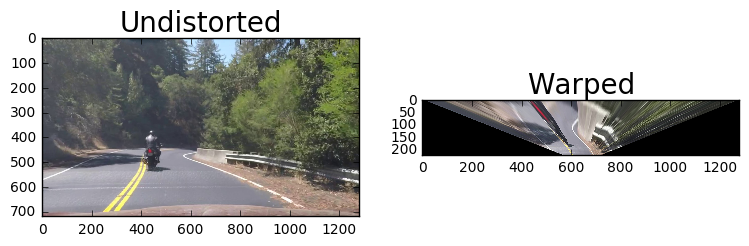

In [5]:
def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def create_M():
    src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
    dst = np.float32([[569, 223], [711, 223], [0, 0], [1280, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def transform(img, M):
    undist = undistort(img)
    img_size = (1280, 223)
    warped = cv2.warpPerspective(undist, M, img_size)
    warped = sharpen_img(warped)
    return warped

def show_warped(img, M):
    f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
    plot1.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
    plot1.set_title('Undistorted', fontsize=20)
    plot2.imshow(cv2.cvtColor(transform(img, M), cv2.COLOR_BGR2RGB))
    plot2.set_title('Warped', fontsize=20)

def show_img(img):
    if len(img.shape)==3:
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.figure()
        plt.imshow(img, cmap='gray')

M, Minv = create_M()
for image in glob.glob('test_images/test*.jpg'):
    img=cv2.imread(image)
    show_warped(img, M)

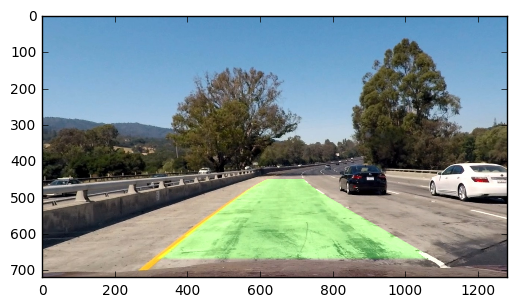

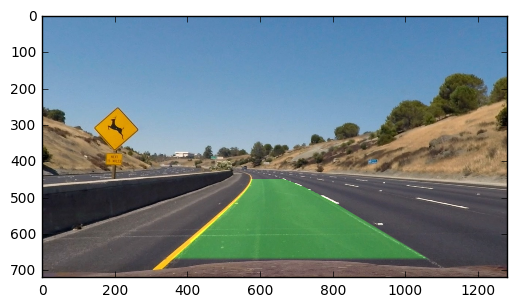

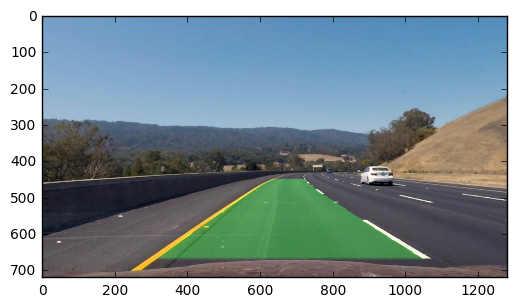

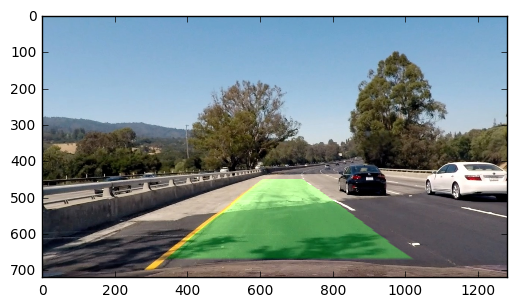

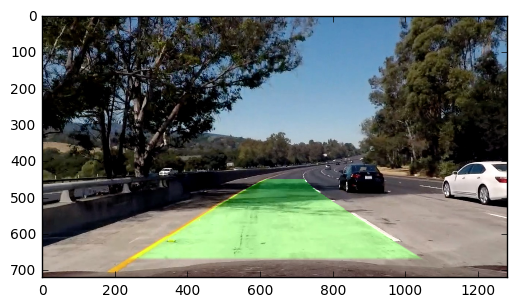

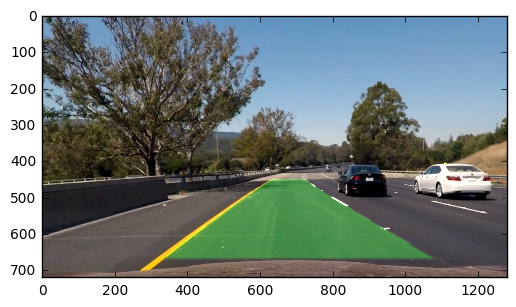

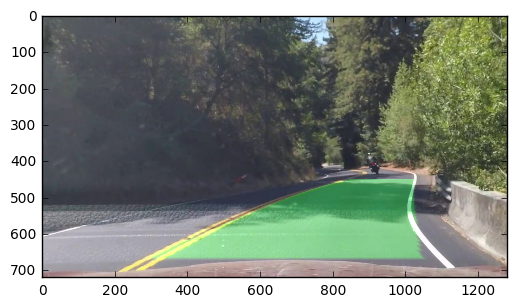

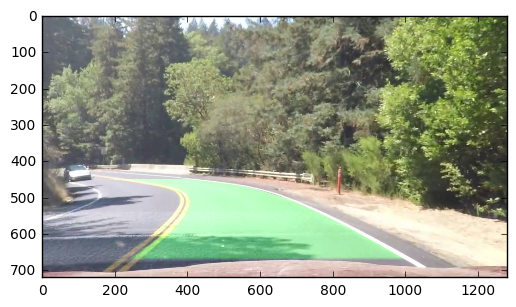

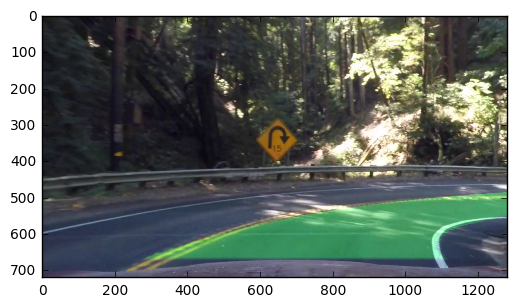

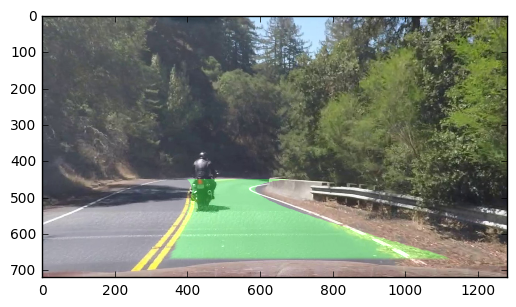

In [7]:
#create virtual sensors

WINDOW_SIZE=20 #20
THRES = 50 #50
DIV = 10 #10

def find(img, left=True, p_ord=2):
    x_pos = []
    y_pos = []
    max_l = img.shape[0] #number of lines in the img
    if left:
        sens = img[max_l-1:max_l,570:630,2]
        x = list(reversed(sens[0,:])).index(max(sens[0,:]))
        x_pos.append(630-x)
    else:
        sens = img[max_l-1:max_l,670:720,2]
        x = list(sens[0,:]).index(max(sens[0,:]))
        x_pos.append(670+x)
    y_pos.append(max_l)
    
    for i in range(1, max_l):
        tech = True
        cent = x_pos[-1]
        sens = img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2]
        x_max = max(sens[0,:])
        if left:
            loc_thres = THRES/2
        else:
            loc_thres = THRES
        if int((x_max-np.mean(sens[0,:])))>loc_thres:
            if len(sens[0,:])<20:
                break
            if left:
                x = list(reversed(sens[0,:])).index(x_max)
                x = cent+WINDOW_SIZE-x
            else:
                x = list(sens[0,:]).index(x_max)
                x = cent-WINDOW_SIZE+x
            y = max_l-i
            if x-1 < 569.0*(max_l-y)/233.0 or x+1> 569.0*(max_l-y)/233.0+711 or np.nonzero(sens[0,:])<WINDOW_SIZE: #if the sensor touchs black triangle
                break
            p = len(x_pos)
            if p > 10:
                coef = np.polyfit(np.array(y_pos[p-10:]), np.array(x_pos[p-10:]), 1)
                x_fit = coef[0]*y+coef[1]
                if abs(x-x_fit) < DIV:
                    x_pos.append(x)
                    y_pos.append(y)
            else:        
                x_pos.append(x)
                y_pos.append(y)
    return np.polyfit(y_pos, x_pos, p_ord), x_pos, y_pos


    
#for image in glob.glob('test_images/ktest1.jpg'):
    #img = cv2.imread(image)
    #show_warped(img,M)
    #img = transform(img, M)
    #img = sharpen_img(img)
    #ploty = np.linspace(0, img.shape[0]-1, num=img.shape[0])
    #left_fit, x, y2 = find(img)
    #print(left_fit)
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #for i in range(len(x)):
        #cv2.circle(img, (x[i], y2[i]), 3, (255,50,250))
    #right_fit, x, y = find(img, False)
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #for i in range(len(x)):
        #cv2.circle(img, (x[i], y[i]), 3, (255,255,50))
    #show_img(img)
    #plt.axis('off')
    #plt.plot(left_fitx, ploty, color='green', linewidth=1)
    #plt.plot(right_fitx, ploty, color='green', linewidth=1)
    #plt.figure()
    #plt.plot(x, y,  'bo')
    
    #y = np.array(y)
    #x = np.array(x)
    #fit = np.poly1d(np.polyfit(y, x, 1))
    #print(coef)
    #print(x)
    #print(y)
    ##x_fit = fit(y)
    #print(x_fit)
    #plt.plot(x_fit, y, color='green', linewidth=1)
def draw_lane_img_p(img_path):
    return cv2.imread(img_path)

    
def get_lane(img, plot=False):
    warp = transform(img, M)
    img = undistort(img)
    ploty = np.linspace(0, warp.shape[0]-1, num=warp.shape[0])
    left_fit, x2, y2 = find(warp)
    l_pol = np.poly1d(left_fit)
    left_fitx = l_pol(ploty)
    right_fit, x, y = find(warp, False)
    r_pol = np.poly1d(right_fit)
    right_fitx = r_pol(ploty)
    if plot:
        for i in range(len(x)):
            cv2.circle(warp, (x[i], y[i]), 3, (255,255,50))
        for i in range(len(x2)):
            cv2.circle(warp, (x2[i], y2[i]), 3, (255,50,250))   
        show_img(warp)
        plt.axis('off')
        plt.plot(left_fitx, ploty, color='green', linewidth=1)
        plt.plot(right_fitx, ploty, color='green', linewidth=1)
    return img,  left_fitx, right_fitx, ploty
    
def draw_lane(img, video=False):
    img, left_fitx, right_fitx, ploty = get_lane(img)
    warp_zero = np.zeros((233,1280)).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    if video:
        return(result)
    else:
        show_img(result)
    

for image in glob.glob('test_images/test*.jpg'):
    draw_lane(draw_lane_img_p(image))

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result=draw_lane(image, True)
    return result


white_output = 'project_video_proc.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4


100%|█████████▉| 1260/1261 [02:56<00:00,  6.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 

CPU times: user 3min 24s, sys: 3.41 s, total: 3min 27s
Wall time: 2min 58s
